# 1 - Analyzing a Real-World Graph

In [ ]:
"""
Graph Mining - ALTEGRAD - Nov 2022
"""

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
############## Task 1

##################
# your code here #
G = nx.read_edgelist("/content/drive/MyDrive/MVA/ALTEGRAD/rendu/Lab4_GALAGAIN_Calvin/CA-HepTh.txt", comments='#', delimiter='\t')

print('Number of nodes:', G.number_of_nodes())
print('Number of edges', G.number_of_edges())
##################

Number of nodes: 9877
Number of edges 25998


In [ ]:
############## Task 2

##################
print('Number of connected components:', nx.number_connected_components(G))

largest_cc = max(nx.connected_components(G), key=len)
subG = G.subgraph(largest_cc)
print(f"The largest connected components has {subG.number_of_edges()} edges ({subG.number_of_edges() / G.number_of_edges():.2f} % of the whole graph).") 
print(f'The largest connected components has {subG.number_of_nodes()} nodes ({subG.number_of_nodes() / G.number_of_nodes():.2f} % of the whole graph).')
##################

Number of connected components: 429
The largest connected components has 24827 edges (0.95 % of the whole graph).
The largest connected components has 8638 nodes (0.87 % of the whole graph).


In [ ]:
############## Task 3
# Degree
degree_sequence = [G.degree(node) for node in G.nodes()]

##################
print('Minimum degree:', np.min(degree_sequence))
print('Maximum degree:', np.max(degree_sequence))
print('Median degree:', np.median(degree_sequence))
print('Mean degree:', np.mean(degree_sequence))
##################

Minimum degree: 1
Maximum degree: 65
Median degree: 3.0
Mean degree: 5.264351523742027


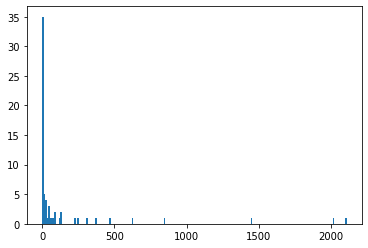

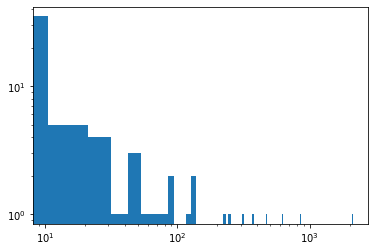

In [ ]:
############## Task 4

##################
plt.hist(nx.degree_histogram(G), bins=200)
plt.show()

plt.hist(nx.degree_histogram(G), bins=200)
plt.xscale('log')
plt.yscale('log')
plt.show()
##################

In [ ]:
############## Task 5

##################
print("Global clustering coefficent :", nx.transitivity(G))
##################

Global clustering coefficent : 0.2839996525875546


# 2 - Comunity Detection

In [ ]:
"""
Graph Mining - ALTEGRAD - Nov 2022
"""

import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans

In [ ]:
############## Task 6
# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):
    
    ##################
    # 1
    A = nx.adjacency_matrix(G)

    # 2
    L_rw = eye(G.number_of_nodes()) - diags([1/G.degree(node) for node in G.nodes()]) @ A

    # 3
    evals, evecs = eigs(L_rw, k=k, which='SR')

    # 4
    kmeans = KMeans(n_clusters=k).fit(np.real(evecs[:,evals.argsort()[::-k]]))
    
    # 5
    clustering = {node: kmeans.labels_[idx] for idx, node in enumerate(G.nodes())}
    ##################
        
    return clustering

In [ ]:
############## Task 7

##################
clustering = spectral_clustering(G, 50)
##################

In [ ]:
############## Task 8
# Compute modularity value from graph G based on clustering
def modularity(G, clustering):
    
    ##################
    clusters = []
    for val in set(clustering.values()):
      one_cluster = []
      for node, cluster in clustering.items():
        if cluster == val:
          one_cluster.append(node)
      clusters.append(one_cluster)
    
    m = len(G.edges)
    modularitys = []

    for cluster in clusters :
      sub_graph = nx.subgraph(G, cluster)
      l_c = sub_graph.number_of_edges()
      d_c = sum(np.array(sub_graph.degree()).T[1].astype(int))
      modularitys.append((l_c/m)-(d_c/(2*m))**2)
    modularity = sum(modularitys)
    ##################
    
    return modularity

In [ ]:
############## Task 9

##################
mod = modularity(G, clustering)
print("Spectral Clustering algorithm (k = 50):", mod)

random_cluster = {node: randint(0, 50) for idx, node in enumerate(G.nodes())}
mod = modularity(G, random_cluster)
print("Random Clustering (k = 50):", mod)
##################

Spectral Clustering algorithm (k = 50): 0.07581345014136226
Random Clustering (k = 50): 0.02049204155377726


# 3 - Graph Classification using Graph Kernels

In [ ]:
"""
Graph Mining - ALTEGRAD - Nov 2022
"""

import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
############## Task 10
# Generate simple dataset
def create_dataset():
  Gs = list()
  y = list()

  ##################
  for size in range(3, 103):
    Gs.append(nx.cycle_graph(size))
    y.append(0)
    Gs.append(nx.path_graph(size))
    y.append(1)
  ##################
  return Gs, y

In [ ]:
Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
  all_paths = dict()
  sp_counts_train = dict()
  
  for i,G in enumerate(Gs_train):
      sp_lengths = dict(nx.shortest_path_length(G))
      sp_counts_train[i] = dict()
      nodes = G.nodes()
      for v1 in nodes:
        for v2 in nodes:
          if v2 in sp_lengths[v1]:
            length = sp_lengths[v1][v2]
            if length in sp_counts_train[i]:
              sp_counts_train[i][length] += 1
            else:
              sp_counts_train[i][length] = 1

            if length not in all_paths:
              all_paths[length] = len(all_paths)
                    
  sp_counts_test = dict()

  for i,G in enumerate(Gs_test):
    sp_lengths = dict(nx.shortest_path_length(G))
    sp_counts_test[i] = dict()
    nodes = G.nodes()
    for v1 in nodes:
      for v2 in nodes:
        if v2 in sp_lengths[v1]:
          length = sp_lengths[v1][v2]
          if length in sp_counts_test[i]:
            sp_counts_test[i][length] += 1
          else:
            sp_counts_test[i][length] = 1

          if length not in all_paths:
            all_paths[length] = len(all_paths)

  phi_train = np.zeros((len(Gs_train), len(all_paths)))
  for i in range(len(Gs_train)):
    for length in sp_counts_train[i]:
        phi_train[i,all_paths[length]] = sp_counts_train[i][length]
  

  phi_test = np.zeros((len(Gs_test), len(all_paths)))
  for i in range(len(Gs_test)):
    for length in sp_counts_test[i]:
        phi_test[i,all_paths[length]] = sp_counts_test[i][length]

  K_train = np.dot(phi_train, phi_train.T)
  K_test = np.dot(phi_test, phi_train.T)

  return K_train, K_test

In [ ]:
############## Task 11
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    
    phi_train = np.zeros((len(G_train), 4))
    
    ##################
    for idx, G in enumerate(Gs_train):
      for _ in range(n_samples):
        s = np.random.choice(G.nodes(), size=3, replace=False)
        subgraph = G.subgraph(s)
        for jdx, graphlet in enumerate(graphlets):
          if nx.is_isomorphic(subgraph, graphlet):
            phi_train[idx, jdx] += 1
    ##################


    phi_test = np.zeros((len(G_test), 4))
    
    ##################
    for idx, G in enumerate(Gs_test):
      for _ in range(n_samples):
        s = np.random.choice(G.nodes(), size=3, replace=False)
        subgraph = G.subgraph(s)
        for jdx, graphlet in enumerate(graphlets):
          if nx.is_isomorphic(subgraph, graphlet):
            phi_test[idx, jdx] += 1
    ##################


    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test


K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)


In [ ]:
############## Task 12

##################
K_train_g, K_test_g = graphlet_kernel(G_train, G_test)
##################

In [ ]:
############## Task 13

##################
clf = SVC(kernel='precomputed')

# shortest path kernel
clf.fit(K_train_sp, y_train)
y_pred = clf.predict(K_test_sp)
print('Classification accuracies of shortest path kernel:', accuracy_score(y_test, y_pred))

clf2 = SVC(kernel='precomputed')
# graphlet kernel
clf2.fit(K_train_g, y_train)
y_pred2 = clf2.predict(K_test_g)
print('Classification accuracies of graphlet kernel:', accuracy_score(y_test, y_pred2))
##################

Classification accuracies of shortest path kernel: 1.0
Classification accuracies of graphlet kernel: 0.5
